<a href="https://colab.research.google.com/github/NULabTMN/hw2-aidasharif1365/blob/master/SequencePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sequence Prediction: Surname Generation

In this experiment, you will explore a simple sequence prediction task: Text generation using a Gated Recurrent Unit (GRU). Like an LSTM, this is an example of a recurrent neural network, but since it has fewer parameters, it should be more appropriate for a smaller dataset.

The GRU computes a probability distribution over the set of possible characters in the surname vocabulary for each time step. We use these probability distributions to generate new surnames. You are given starter code that trains a SurnameGenerationModel on the [surname dataset](https://github.com/jasoriya/CS6120-PS2-support/blob/master/data/surnames/surnames_with_splits.csv) to generate new surnames by learning from the training data. 



Your task is to understand this code and plot the over all perplxity of GRU model as a function of the hidden representation size (K) and the number of characters already observed. You will see **TODO** prompts in the following cells

## Imports

In [103]:
import os
from argparse import Namespace
import numpy as np
import httpimport
import torch
import torch.optim as optim
from tqdm import tqdm_notebook
from torch.nn import functional as F
import collections

# import data preprocessing and modeling functions from https://github.com/jasoriya/CS6120-PS2-support/tree/master/utils
with httpimport.remote_repo(['data_vectorization','model','helper'], 'https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/utils/'):
  from data_vectorization import Vocabulary, SequenceVocabulary, SurnameVectorizer, SurnameDataset, generate_batches
  from model import SurnameGenerationModel, sample_from_model, decode_samples
  from helper import make_train_state, update_train_state, normalize_sizes, compute_accuracy, sequence_loss, set_seed_everywhere, handle_dirs


### Settings and some prep work

**TODO**: 
- Give path to a directory where the model should be saved
- Give hidden state size (`rnn_hidden_size`) for the GRU model (experiment with different levels)


In [104]:
args = Namespace(
    # Data and Path information
    surname_csv="https://raw.githubusercontent.com/jasoriya/CS6120-PS2-support/master/data/surnames/surnames_with_splits.csv",
    vectorizer_file="vectorizer.json",
    model_state_file="model.pth",
    save_dir= "https://github.com/NULabTMN/hw2-aidasharif1365", # give path here
    # Model hyper parameters
    char_embedding_size=32,
    rnn_hidden_size= 16, # give hidden size
    # Training hyper parameters
    seed=1337,
    learning_rate=0.005,# I had to change the lr to accelerate training
    batch_size=128,
    num_epochs=50,# I had to change the #epochs to accelerate training
    early_stopping_criteria=5,
    # Runtime options
    catch_keyboard_interrupt=True,
    cuda=True,
    expand_filepaths_to_save_dir=True,
    reload_from_files=False,
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    
    
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))

# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	https://github.com/NULabTMN/hw2-aidasharif1365/vectorizer.json
	https://github.com/NULabTMN/hw2-aidasharif1365/model.pth
Using CUDA: True


### Initializations

In [105]:
if args.reload_from_files:
    # training from a checkpoint
    dataset = SurnameDataset.load_dataset_and_load_vectorizer(args.surname_csv,
                                                              args.vectorizer_file)
else:
    # create dataset and vectorizer
    dataset = SurnameDataset.load_dataset_and_make_vectorizer(args.surname_csv)
    dataset.save_vectorizer(args.vectorizer_file)

vectorizer = dataset.get_vectorizer()

model = SurnameGenerationModel(char_embedding_size=args.char_embedding_size,
                               char_vocab_size=len(vectorizer.char_vocab),
                               rnn_hidden_size=args.rnn_hidden_size,
                               padding_idx=vectorizer.char_vocab.mask_index)

### Training loop

In [106]:
mask_index = vectorizer.char_vocab.mask_index

model = model.to(args.device)


optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                           mode='min', factor=0.5,
                                           patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm_notebook(desc='training routine', 
                          total=args.num_epochs,
                          position=0)

dataset.set_split('train')
train_bar = tqdm_notebook(desc='split=train',
                          total=dataset.get_num_batches(args.batch_size), 
                          position=1, 
                          leave=True)
dataset.set_split('val')
val_bar = tqdm_notebook(desc='split=val',
                        total=dataset.get_num_batches(args.batch_size), 
                        position=1, 
                        leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on
        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        model.train()
        
        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------    
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)


            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss,
                                  acc=running_acc,
                                  epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        model.eval()

        for batch_index, batch_dict in enumerate(batch_generator):
            # compute the output
            y_pred = model(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

            # compute the  running loss and running accuracy
            running_loss += (loss.item() - running_loss) / (batch_index + 1)
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            
            # Update bar
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=model, 
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break
        
        # move model to cpu for sampling
        model = model.cpu()
        sampled_surnames = decode_samples(
            sample_from_model(model, vectorizer, num_samples=2), 
            vectorizer)
        epoch_bar.set_postfix(sample1=sampled_surnames[0], 
                              sample2=sampled_surnames[1])
        # move model back to whichever device it should be on
        model = model.to(args.device)
        
        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
        
except KeyboardInterrupt:
    print("Exiting loop")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [107]:
np.random.choice(np.arange(len(vectorizer.nationality_vocab)), replace=True, size=2)

array([8, 7])

In [108]:
# compute the loss & accuracy on the test set using the best available model

model.load_state_dict(torch.load(train_state['model_filename']))

model = model.to(args.device)

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_acc = 0.
model.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred = model(x_in=batch_dict['x_data'])

    # compute the loss
    loss = sequence_loss(y_pred, batch_dict['y_target'], mask_index)

    # compute the accuracy
    running_loss += (loss.item() - running_loss) / (batch_index + 1)

    acc_t = compute_accuracy(y_pred, batch_dict['y_target'], mask_index)
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss 
train_state['test_acc'] = running_acc 

**TODO**: Write code to compute the perplexity of the test corpus, the accuracy of a character-prediction task, and the perplexity of the predictive distribution given increasing amounts of context. For this last metric, you want to compute the perplexity of predicting the first character (given nothing to the left), the perplexity of predicting the second character (given the first), and so on, up to the perplexity of predicting the n-th character (given the first 1 to n-1 characters). Unlike an n-gram model, the recurrent model can encode arbitrarily long histories, although it will probably make more use of the nearby context.

In [109]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test perplexity: {};".format(2**loss)) # compute and print perplexity here
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 2.9066432515780134;
Test perplexity: 7.443632125854492;
Test Accuracy: 17.182484222756695


In [118]:
#finding the preplexity for each character in each test sample
#first we normalize y_pred and y_true
y_pred,y_true=normalize_sizes(y_pred,batch_dict['y_target'])
#following the same steps in original code
sequence_loss=F.cross_entropy(y_pred,y_true,ignore_index=mask_index,reduction='none')
sequence_loss=sequence_loss.view(128,19)
#making a dictionary to add up all perplexitis for each character in all samples
sum_char=collections.defaultdict(int)

for ch in range(len(sequence_loss[1])):
  for test in range(len(sequence_loss[0])):
    sum_char[ch]=sum_char[ch]+(sequence_loss[test][ch]).item()
    
#array to save the final average
array1=[]
for key in sum_char:
  array1.append(2**(sum_char[key]/128))

print(array1)

[1.4062597399617625, 1.3330298009987398, 1.3754004664025754, 1.386251018234484, 1.302790610034732, 1.2441376037172014, 1.1803756873380795, 1.0876212538801793, 1.0326269920636182, 1.0187816618795307, 1.004699113892108, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [119]:
#finding the accuracy for each character in each test sample
#first we normalize y_pred and y_true
y_pred,y_true=normalize_sizes(y_pred,batch_dict['y_target'])
_, y_pred_indices = y_pred.max(dim=1)
#following the same steps in original code
correct_indices = torch.eq(y_pred_indices, y_true)
valid_indices = torch.ne(y_true, mask_index)
correct_indices=correct_indices.view(128,19)
valid_indices=valid_indices.view(128,19)
#making a dictionary to add up all accuracies for each character in all samples
sum_char=collections.defaultdict(int)

n_correct=(correct_indices[:,0].float()*valid_indices[:,0].float()).sum().item()
n_valid=valid_indices[:,0].float().sum().item()

#array to save the final average
array2=[]

for i in range(19):
  n_correct=(correct_indices[:,i].float()*valid_indices[:,i].float()).sum().item()
  n_valid=valid_indices[:,i].float().sum().item()

  if n_correct<=1 and n_correct<=1:
    array2.append(100)
  else:
    array2.append(n_correct/(n_valid)*100)

print(array2)

[10.15625, 17.96875, 4.6875, 8.73015873015873, 9.090909090909092, 15.315315315315313, 25.0, 42.25352112676056, 38.095238095238095, 30.76923076923077, 44.44444444444444, 60.0, 100.0, 100, 100, 100, 100, 100, 100]


## Inference
To see the names that the model generates:

In [117]:
# number of names to generate
num_names = 10
model = model.cpu()
# Generate nationality hidden state
sampled_surnames = decode_samples(
    sample_from_model(model, vectorizer, num_samples=num_names), 
    vectorizer)
# Show results
print ("-"*15)
for i in range(num_names):
    print (sampled_surnames[i])

---------------
Aoereyrukd
Evdnsa
Lou
Hoê
Mryaao
Hrokyhti
Kakidrtt
Haljo
Bonkhiaatno
Kai


**TODO**: Train the GRU model given above multiple times for different levels of `rnn_hidden_size`. For each of these models, plot the average perplexity as a function of the number of characters of the name observed so far. Explain your observations.

In [112]:
#these numbers are the result of changing the rnn size, _number indicates the size
perplex_2=[1.489671525127142, 1.3621895177048202, 1.3608732283724683, 1.3658805538383052, 1.3419343993012065, 1.3451225391737462, 1.2628806722040768, 1.1910238292369568, 1.1960240364620134, 1.071581657351805, 1.0255024617838224, 1.0208172706803271, 1.012244012068921, 1.012947141057863, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_3=[1.4542813795360545, 1.2885177313109617, 1.4341591608212994, 1.402610818838211, 1.3184224211406832, 1.3563371487684517, 1.2435774743030026, 1.1546553012893277, 1.0925371848703669, 1.0173685855478314, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_4=[1.4062597399617625, 1.3330298009987398, 1.3754004664025754, 1.386251018234484, 1.302790610034732, 1.2441376037172014, 1.1803756873380795, 1.0876212538801793, 1.0326269920636182, 1.0187816618795307, 1.004699113892108, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_8= [1.3796550751251913,1.2337345705243767, 1.3686483542523569, 1.352187031405532, 1.2863526995640941,1.3221248546913964, 1.2820658585523763, 1.1554332379437122, 1.092944415598672,1.0681427637320002, 1.020535114118293, 1.022091500704106, 1.0215047096372418,1.0091926795623982, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_12=[1.3413757460430336, 1.3244590987145413, 1.3111965373006471, 1.3870858934438328, 1.2982008600931385, 1.2239544712594683, 1.164047908431632, 1.1071931883498358, 1.077211592573045, 1.0535566324341301, 1.0136144996161132, 1.0124176872166073, 1.0028692673307413, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_16=[1.3512476960711195, 1.2601728358095585, 1.340157602479801, 1.3538397556916146, 1.3655963533345163, 1.2555499230364136, 1.191938479467736, 1.1331005790166546, 1.051942752325747, 1.0410259935477, 1.0203282523096178, 1.00544844915301, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_20=[1.3714015659246261, 1.2123681494054004, 1.3574470504608735, 1.3272099191877522, 1.3240532181669729, 1.3479077011578227, 1.207178981067097, 1.0560396342378555, 1.0492725929343472, 1.0208831696966314, 1.0019857197896636, 1.0091052048567215, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
perplex_32=[1.3693218548358852, 1.3034494019969733,1.2993963555105248, 1.344851709226716, 1.3152711685122744, 1.2272038578579672,1.1179164262890369, 1.0679714230729542, 1.012973518451812, 1.030459908717184,1.0405237048488885, 1.0024140354916986, 1.0041361611396649, 1.0, 1.0, 1.0, 1.0,1.0, 1.0]
perplex_40=[1.3490522127005722, 1.2075534996512094, 1.3581790350878216, 1.3050767252388968, 1.355766984017641, 1.2006675639484043, 1.1545044282732384, 1.1041318879028197, 1.065263726934363, 1.0437090217530223, 1.0094076021996168, 1.0303036501805585, 1.0194860046032488, 1.013250040844631, 1.0021429545406673, 1.0, 1.0, 1.0, 1.0]
perplex_50=[1.3654661040662421, 1.2337546050696415, 1.3216017445373338, 1.3157741123010107, 1.240449346342775, 1.2642965027684783, 1.212989288429832, 1.1526496781532476, 1.0593580405237366, 1.01433749220229, 1.0090242170237134, 1.0130722126834757, 1.0025613739683568, 1.0015273508793987, 1.0, 1.0, 1.0, 1.0, 1.0]


In [113]:
#these numbers are the result of changing the rnn size, _number indicates the size
acc_2=[5.46875, 31.25, 8.59375, 11.904761904761903, 9.917355371900827, 12.612612612612612, 12.371134020618557, 23.684210526315788, 15.09433962264151, 18.181818181818183, 43.75, 50.0, 100, 100, 100, 100, 100, 100, 100]
acc_3=[7.03125, 29.6875, 5.46875, 10.15625, 11.29032258064516, 19.130434782608695, 26.666666666666668, 25.862068965517242, 35.8974358974359, 43.47826086956522, 53.84615384615385, 40.0, 66.66666666666666, 100, 100, 100, 100, 100, 100]
acc_4=[10.15624920654303, 17.968748596191517,4.687499633789091, 8.730158037289044, 9.090908339594352, 15.315313935557304,24.999997395833603, 42.25351517556124, 38.09522902494547, 30.76921893491579,44.44441975310014, 59.99994000006, 99.99975000062501, 100, 100, 100, 100, 100,100]
acc_8=[4.6875, 25.78125, 10.9375, 10.15625, 12.903225806451612, 20.869565217391305, 27.083333333333332, 41.0958904109589, 47.61904761904761, 40.909090909090914, 54.54545454545454, 80.0, 100, 100.0, 100, 100, 100, 100, 100]
acc_12=[5.46875, 25.78125, 11.71875, 12.5, 26.82926829268293, 18.095238095238095, 25.842696629213485, 41.37931034482759, 45.714285714285715, 50.0, 66.66666666666666, 50.0, 50.0, 100, 100.0, 100, 100, 100, 100]
acc_16=[12.5, 30.46875, 21.09375, 6.299212598425196, 22.22222222222222, 26.956521739130434, 32.608695652173914, 50.0, 44.44444444444444, 52.17391304347826, 63.63636363636363, 100.0, 100, 100, 100, 100, 100, 100, 100]
acc_20=[7.8125, 32.8125, 15.625, 11.811023622047244, 21.311475409836063, 26.08695652173913, 32.29166666666667, 41.269841269841265, 40.909090909090914, 33.33333333333333, 64.28571428571429, 50.0, 100.0, 100, 100, 100, 100, 100, 100]
acc_32=[11.71875, 33.59375, 19.53125, 21.6, 26.01626016260163, 28.947368421052634, 36.36363636363637, 47.22222222222222, 47.82608695652174, 61.29032258064516, 38.46153846153847, 55.55555555555556, 25.0, 100, 100, 100, 100, 100, 100]
acc_40=[7.8125, 44.53125, 14.84375, 19.68503937007874, 25.0, 27.927927927927925, 45.55555555555556, 52.54237288135594, 52.63157894736842, 66.66666666666666, 66.66666666666666, 100, 100, 100.0, 100.0, 100, 100, 100, 100]
acc_50=[6.25, 32.8125, 13.28125, 19.047619047619047, 25.40983606557377, 32.17391304347826, 42.5531914893617, 42.028985507246375, 56.25, 64.51612903225806, 78.94736842105263, 42.857142857142854, 60.0, 66.66666666666666, 100.0, 100, 100, 100, 100]


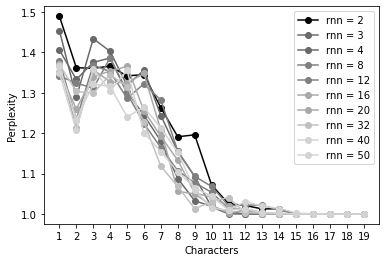

In [114]:
import matplotlib.pyplot as plt
x_ax=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
plt.plot(x_ax,perplex_2,marker="o",color='black', label="rnn = 2")
plt.plot(x_ax,perplex_3,marker="o",color='dimgray', label="rnn = 3")
plt.plot(x_ax,perplex_4,marker="o",color='dimgrey', label="rnn = 4")
plt.plot(x_ax,perplex_8,marker="o",color='gray', label="rnn = 8")
plt.plot(x_ax,perplex_12,marker="o",color='grey', label="rnn = 12")
plt.plot(x_ax,perplex_16,marker="o",color='darkgray', label="rnn = 16")
plt.plot(x_ax,perplex_20,marker="o",color='darkgrey', label="rnn = 20")
plt.plot(x_ax,perplex_32,marker="o",color='silver', label="rnn = 32")
plt.plot(x_ax,perplex_40,marker="o",color='lightgray', label="rnn = 40")
plt.plot(x_ax,perplex_50,marker="o",color='lightgrey', label="rnn = 50")
plt.legend(loc="upper right")
plt.ylabel('Perplexity')
plt.xlabel('Characters')
plt.xticks(x_ax,x_ax)
plt.show()


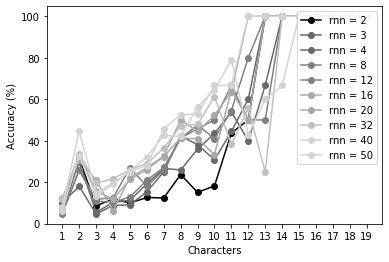

In [116]:
import matplotlib.pyplot as plt
x_ax=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19]
fig = plt.figure()
plt.plot(x_ax,acc_2,marker="o",color='black', label="rnn = 2")
plt.plot(x_ax,acc_3,marker="o",color='dimgray', label="rnn = 3")
plt.plot(x_ax,acc_4,marker="o",color='dimgrey', label="rnn = 4")
plt.plot(x_ax,acc_8,marker="o",color='gray', label="rnn = 8")
plt.plot(x_ax,acc_12,marker="o",color='grey', label="rnn = 12")
plt.plot(x_ax,acc_16,marker="o",color='darkgray', label="rnn = 16")
plt.plot(x_ax,acc_20,marker="o",color='darkgrey', label="rnn = 20")
plt.plot(x_ax,acc_32,marker="o",color='silver', label="rnn = 32")
plt.plot(x_ax,acc_40,marker="o",color='lightgray', label="rnn = 40")
plt.plot(x_ax,acc_50,marker="o",color='lightgrey', label="rnn = 50")
plt.legend(loc="upper right")
plt.ylabel('Accuracy (%)')
plt.xlabel('Characters')
plt.xticks(x_ax,x_ax)
plt.show()

In [ ]:
Explanation:


The results clearly show that by increasing the number of rnn hidden layers the perplexity for each character decreases which means that the model is able to learn the language better, in other words higher hidden layes make the model more complex and such complexity helps the model to learn more details from the language. However, after adding up to 20 hidden layers the performance does not improve much anymore, it would be better to stop 1t 20 layesr since higher values takes much longer time to be trained while the preformance does not change. The worst results are for hidden layer size=2 and the best results are for hidden layer=50.

The same result can be seen in accuracy, adding more layesr help to improve the accuray at each of the 19 character positions. There are some drops and jumps in the plot and the reason is that i had to decrease number of empochs from 100 to 50 and the learning rate from 0.001 to 0.005 in order to prevent my code from crashing. 

In terms of perplexity at each character it is clear that by adding more characters, model does a better job at predicting the next character, the accuracy of such predictions also improves.

When the model reaches to the last character which is less than 19, the rest of the prediction has 100% accuracy and perplexity of 1. 


